In [1]:
import json
import os
import pathlib
import time
import matplotlib
import glob

import numpy as np
import rasterio
from rasterio.plot import show
import requests
from requests.auth import HTTPBasicAuth

In [2]:
os.environ['PL_API_KEY']='222f5fae886d4c4d856bd52e22db62be'

In [3]:
# The 8 sensor locations used for this research.
CAMS = [0,1,2,3,4,5,6,7]
CAMS[0] = ['1604', -97.6649360, 29.8649170]
CAMS[1] = ['6602', -97.5417940, 30.5457060]
CAMS[2] = ['1612', -97.2937410, 30.1082220]
CAMS[3] = ['0614', -98.0833473, 30.2146162]
CAMS[4] = ['1613', -97.3785080, 30.3478080]
CAMS[5] = ['1675', -97.9288560, 29.8622810]
CAMS[6] = ['1603', -97.8937440, 30.2163970]
CAMS[7] = ['0690', -97.7345790, 30.6664421]

# API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Search parameters
## The type of band procured.
item_type = "PSScene4Band"
## The radius of the search box in decimal degrees.
size = .05
## The year of the search.
year = 2018
## The maximum amount of cloud cover allowed per image.
cloud_cover_lte = 0.25
## Used for Image IDs
same_src_products = [0]
# Array used to store list of downloadable image clips in groups of 100.
download_items = []
# Global order ID used to globally store the order IDs.
global_order_id = '0'

In [4]:
# define helpful functions for submitting, polling, and downloading an order
def place_order(request, auth):
    response = requests.post(orders_url, data=json.dumps(request), auth=auth, headers=headers)
    print(response)
    
    if not response.ok:
        raise Exception(response.content)

    order_id = response.json()['id']
    print(order_id)
    global_order_id = order_id
    order_url = orders_url + '/' + order_id
    return order_url

def poll_for_success(order_url, auth, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        r = requests.get(order_url, auth=auth)
        response = r.json()
        state = response['state']
        print(state)
        success_states = ['success', 'partial']
        if state == 'failed':
            raise Exception(response)
        elif state in success_states:
            break
        
        time.sleep(10)
        
def download_order(order_url, auth, overwrite=False):
    r = requests.get(order_url, auth=auth)
    print(r)
    response = r.json()
    print(response)
    results = response['_links']['results']
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    results_paths = [pathlib.Path(os.path.join('data', n)) for n in results_names]
    print('{} items to download'.format(len(results_urls)))
    
    for url, name, path in zip(results_urls, results_names, results_paths):
        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            r = requests.get(url, allow_redirects=True)
            path.parent.mkdir(parents=True, exist_ok=True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))
            
    return dict(zip(results_names, results_paths))

# define helpful functions for visualizing downloaded imagery
def show_rgb(img_file):
    with rasterio.open(img_file) as src:
        b,g,r,n = src.read()

    rgb = np.stack((r,g,b), axis=0)
    show(rgb/rgb.max())
    
def show_gray(img_file):
    with rasterio.open(img_file) as src:
        g = src.read(1)
    show(g/g.max())

# This function takes coordinates and a size (in degrees) to create a geojson bounding box.
def get_bounding_box(coordinates, size):
    # Bounding Box around a CAMS.
    geojson_geometry = {
      "type": "Polygon",
      "coordinates": [
        [ 
          [coordinates[1] - size, coordinates[2] + size],
          [coordinates[1] + size, coordinates[2] + size],
          [coordinates[1] + size, coordinates[2] - size],
          [coordinates[1] - size, coordinates[2] - size],
          [coordinates[1] - size, coordinates[2] + size]
        ]
      ]
    }
    return geojson_geometry

# This function takes the Area of Interest (AOI), year, month, and desired cloud cover parameter to create a combined filter. 
def create_filter(AOI, year, month, lte_clouds):
    geometry_filter = {
      "type": "GeometryFilter",
      "field_name": "geometry",
      "config": AOI
    }
    
    # Adds a 0 if the number representing the month is less than 10 and does not add a 0 otherwise.
    if month <= 9:
        gte_date = str(year) + '-0' + str(month) + '-01T00:00:00.000Z';
        if month == 9:
            lte_date = str(year) + '-' + str(month+1) + '-01T00:00:00.000Z';
        else:
            lte_date = str(year) + '-0' + str(month+1) + '-01T00:00:00.000Z';
    elif month > 9 & month <= 99:
        gte_date = str(year) + '-' + str(month) + '-01T00:00:00.000Z';
        if month == 12:
            lte_date = str(year + 1) + '-01-01T00:00:00.000Z';
        else:
            lte_date = str(year) + "-" + str(month+1) + '-01T00:00:00.000Z';
    
    # get images acquired within a date range
    date_range_filter = {
      "type": "DateRangeFilter",
      "field_name": "acquired",
      "config": {
        "gte": gte_date,
        "lte": lte_date
      }
    }

    # only get images which have less than 1% cloud coverage
    cloud_cover_filter = {
      "type": "RangeFilter",
      "field_name": "cloud_cover",
      "config": {
        "lte": lte_clouds
      }
    }

    # combine our geo, date, cloud filters
    combined_filter = {
      "type": "AndFilter",
      "config": [geometry_filter, date_range_filter, cloud_cover_filter]
    }

    return combined_filter

In [5]:
# Runs the combined filter for each CAMS and for each month.
# for i in range(0,8):
#     geojson_geometry = get_bounding_box(CAMS[i], size)
#     for month in range(1,13):
#         combined_filter = create_filter(geojson_geometry, year, month, cloud_cover_lte)

# Runs the combined filter for 1 CAM and all 12 months to determine what images are available for download.
for i in range(0,1):
    geojson_geometry = get_bounding_box(CAMS[i], size)
    for month in range(3,4):
        combined_filter = create_filter(geojson_geometry, year, month, cloud_cover_lte)
        print('CAMS-' + str(CAMS[i][0]) + ", " + str(month) + "-" + str(year))
        # API request object
        search_request = {
          "interval": "day",
          "item_types": [item_type], 
          "filter": combined_filter
        }
        # fire off the POST request
        search_result =           requests.post(
            'https://api.planet.com/data/v1/quick-search',
            auth=HTTPBasicAuth(PLANET_API_KEY, ''),
            json=search_request)
        
        # extract image IDs
        image_ids = [feature['id'] for feature in search_result.json()['features']]
        # extract the origin_x and origin_y
        origin_x = [feature['properties']['origin_x'] for feature in search_result.json()['features']]
        origin_y = [feature['properties']['origin_y'] for feature in search_result.json()['features']]
        epsg_code = [feature['properties']['epsg_code'] for feature in search_result.json()['features']]
        cloud_cover = [feature['properties'] for feature in search_result.json()['features']]
        # Use the version 2 of orders API to clip images to the area of interest after item id acquisition.
        orders_url = 'https://api.planet.com/compute/ops/orders/v2'

        # set up requests to work with api
        auth = HTTPBasicAuth(PLANET_API_KEY, '')
        headers = {'content-type': 'application/json'}

        # define products part of order
        same_src_products = [
            {
              "item_ids": image_ids,
              "item_type": "PSScene4Band",
              "product_bundle": "analytic_sr"
            }
        ]

        # Create a temporary variable to store an array.
        items = 'No Value'
        # For filling the index of composites.
        z = 0
        # Empty array.
        composite_items = [[]]
        
        # Only puts images with Surface Reflectance data in the download items list.
        for x in range(0,len(same_src_products[i]['item_ids'])):
            if len(same_src_products[i]) > 0:
                # Using print to test the output.
                #print(same_src_products[i]['item_ids'][x])
                # Grab the image ID
                id0 = same_src_products[i]['item_ids'][x]
                id0_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(item_type, id0)
                
                # Returns JSON metadata for assets in this ID. Learn more: planet.com/docs/reference/data-api/items-assets/#asset
                result =                   requests.get(
                    id0_url,
                    auth=HTTPBasicAuth(PLANET_API_KEY, '')
                  )
                
                # List of asset types available for this particular satellite image
                if 'analytic_sr' in list(result.json().keys()):
                    if items == 'No Value':
                        items = 'Value'
                        print(id0)
                        composite_items[z] = [id0]
                        temp_composite = id0
                    elif temp_composite[0:8] == id0[0:8]:
                        composite_items[z].extend([id0])
                        print(id0)
                        temp_composite = id0
                    elif temp_composite[0:8] != id0[0:8]:
                        z = z + 1
                        composite_items.extend([[id0]])
                        print(id0)
                        temp_composite = id0

CAMS-1604, 3-2018
20180330_163527_1038
20180330_163526_1038
20180330_163525_1038
20180319_163616_0f22
20180319_163615_0f22
20180319_163614_0f22
20180326_163504_1006
20180326_163505_1006
20180326_163503_1006
20180322_170430_0f3b
20180321_163629_1012
20180314_170554_104d
20180314_163619_0f51
20180314_163618_0f51
20180314_163617_0f51
20180314_170553_104d
20180314_170552_104d
20180312_163517_1036
20180312_163516_1036
20180312_163515_1036
20180306_163410_1035
20180306_163409_1035
20180301_163534_0f51
20180301_163533_0f51
20180301_163532_0f51


In [6]:
## Find the composite with the most frames, at the earliest date to build a mosaic from.
for i in range(0,len(composite_items)):
    if i == 0:
        max_frames = len(composite_items[i])
    if i > 0 and len(composite_items[i]) >= max_frames:
        max_frames = len(composite_items[i])
        items = composite_items[i]

In [7]:
## EDUCATION LICENSES DO NOT HAVE COMPOSITE CAPABILITY
same_src_products = [
    {
      "item_ids": items,
      "item_type": "PSScene4Band",
      "product_bundle": "analytic_sr"
    }
]

composite = {  
   "composite":{  
   }
}

composite_request = {
  "name": "composite",
  "products": same_src_products,
  "tools": [composite]
}

run_composite = True

if run_composite:
    composite_order_url = place_order(composite_request, auth)
    poll_for_success(composite_order_url, auth)
    downloaded_composite_files = download_order(composite_order_url, auth)
    composite_file = next(downloaded_composite_files[d] for d in downloaded_composite_files
                          if d.endswith('composite.tif'))
    
show_rgb(composite_file)

<Response [400]>


Exception: b'{"field":null,"general":[{"message":"Unable to accept order: Your organisation does not have permission to run the \'composite\' tool"}]}\n'

In [8]:
# Get the clipping area.
clip_aoi = get_bounding_box(CAMS[0], size)

# define the clip tool
clip = {
    "clip": {
        "aoi": clip_aoi
    }
}

# create an order request with the clipping tool
request_clip = {
  "name": "just clip",
  "products": same_src_products,
  "tools": [clip]
}

# allow for caching so we don't always run clip
run_clip = True

if run_clip:
    clip_order_url = place_order(request_clip, auth)
    poll_for_success(clip_order_url, auth)
    downloaded_clip_files = download_order(clip_order_url, auth)
    clip_img_file = next(downloaded_clip_files[d] for d in downloaded_clip_files
                     if d.endswith('_3B_AnalyticMS_SR_clip.tif'))
    clip_img_file

<Response [202]>
d2583d08-7132-4c57-8921-41d83edfe7d9
queued
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
success
<Response [429]>


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

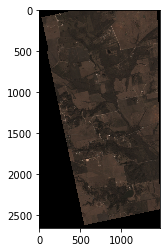

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/2/files/20180114_171410_0f2e_3B_AnalyticMS_SR_clip.tif


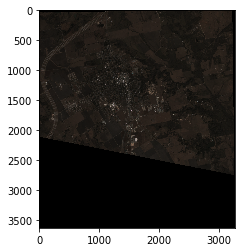

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/3/files/20180114_163225_102f_3B_AnalyticMS_SR_clip.tif


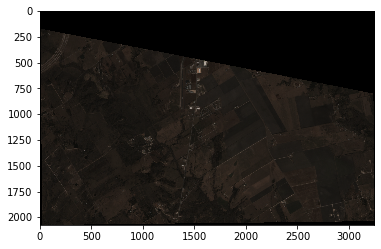

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/4/files/20180114_163226_102f_3B_AnalyticMS_SR_clip.tif


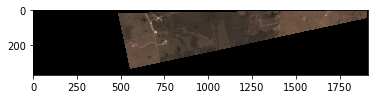

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/6/files/20180114_171411_0f2e_3B_AnalyticMS_SR_clip.tif


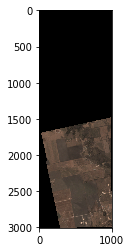

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/1/files/20180114_171409_0f2e_3B_AnalyticMS_SR_clip.tif


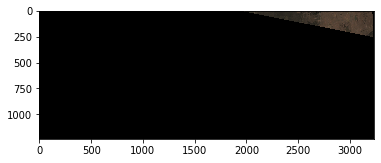

data/a43a2739-75e9-43e6-9343-a4e6cc714c16/5/files/20180114_163224_102f_3B_AnalyticMS_SR_clip.tif

Processing file     1 of     6,  0.000% completed in 0 minutes.
Filename: data/a43a2739-75e9-43e6-9343-a4e6cc714c16/2/files/20180114_171410_0f2e_3B_AnalyticMS_SR_clip.tif
File Size: 1469x2654x4
Pixel Size: 3.000000 x -3.000000
UL:(629397.000000,3310164.000000)   LR:(633804.000000,3302202.000000)
Copy 0,0,1469,2654 to 1782,0,1469,2654.
Copy 0,0,1469,2654 to 1782,0,1469,2654.
Copy 0,0,1469,2654 to 1782,0,1469,2654.
Copy 0,0,1469,2654 to 1782,0,1469,2654.

Processing file     2 of     6, 16.667% completed in 0 minutes.
Filename: data/a43a2739-75e9-43e6-9343-a4e6cc714c16/3/files/20180114_163225_102f_3B_AnalyticMS_SR_clip.tif
File Size: 3263x3633x4
Pixel Size: 3.000000 x -3.000000
UL:(624051.000000,3310164.000000)   LR:(633840.000000,3299265.000000)
Copy 0,0,3263,3633 to 0,0,3263,3633.
Copy 0,0,3263,3633 to 0,0,3263,3633.
Copy 0,0,3263,3633 to 0,0,3263,3633.
Copy 0,0,3263,3633 to 0,0,3263,3633.

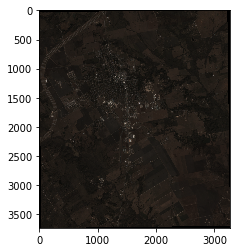

Driver: GTiff/GeoTIFF
Files: /media/davidm/Data-Disk/environments/image_segmentation/output.tif
Size is 3264, 3732
Coordinate System is:
PROJCS["WGS 84 / UTM zone 14N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-99],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32614"]]
Origin = (624051.000000000000000,3310164.000000000000000)
Pixel Size = (3.000000000000000,-3.00

In [11]:
all_files = ''
global_order_id = 'a43a2739-75e9-43e6-9343-a4e6cc714c16'
for i in glob.glob('data/' + global_order_id + '/*'):
    dir_beginning = i
    for name in glob.glob(i + '/files/*'):
         if name.endswith('_3B_AnalyticMS_SR_clip.tif'):
            show_rgb(name)
            all_files = all_files + name + ' '
            print(name)
            location = '/media/davidm/Data-Disk/environments/image_segmentation/' + name
!gdal_merge.py -v $all_files -o 'output.tif'
show_rgb('output.tif')
output = '/media/davidm/Data-Disk/environments/image_segmentation/output.tif'
!gdalinfo $output

(3732, 3264)


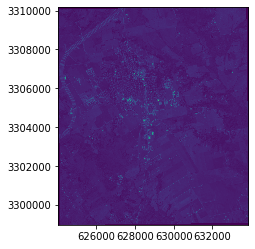

In [12]:
src = rasterio.open("output.tif")
print(src.shape)
type(src)
rasterio.plot.show(src)